In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

The images are processed in the batch size of 32. Each image isresized in 256 by 256.

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Mango",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 435 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['diseased', 'healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1]


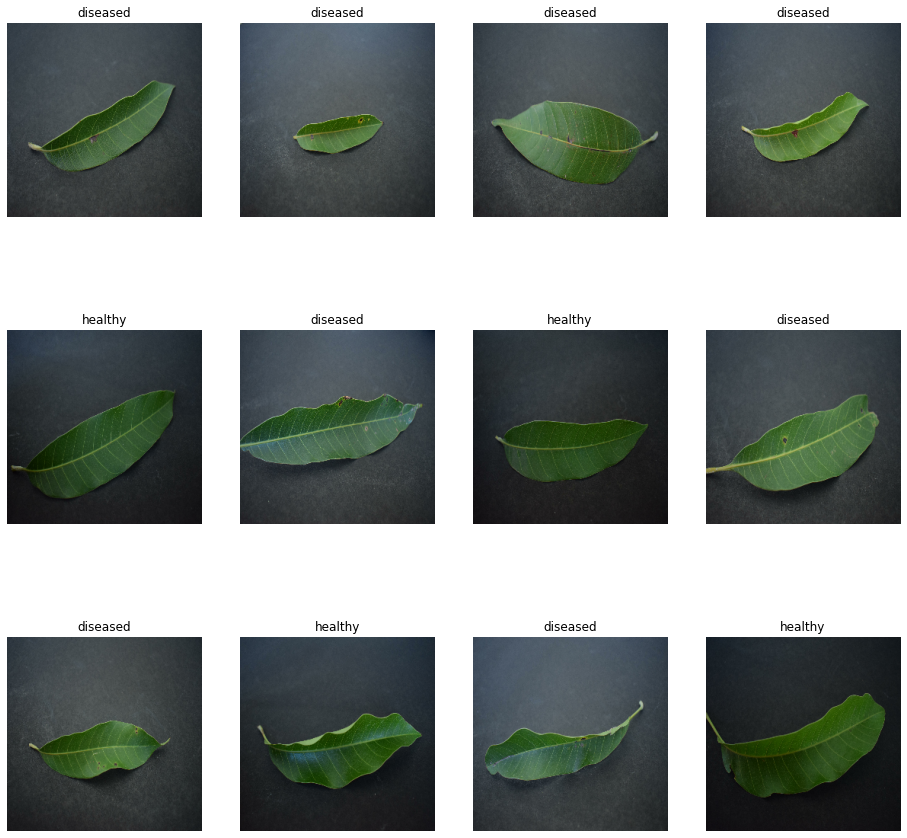

In [6]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

The entire dataset is splitted into training, validation and testing dataset in the proprtion of 8:1:1.

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

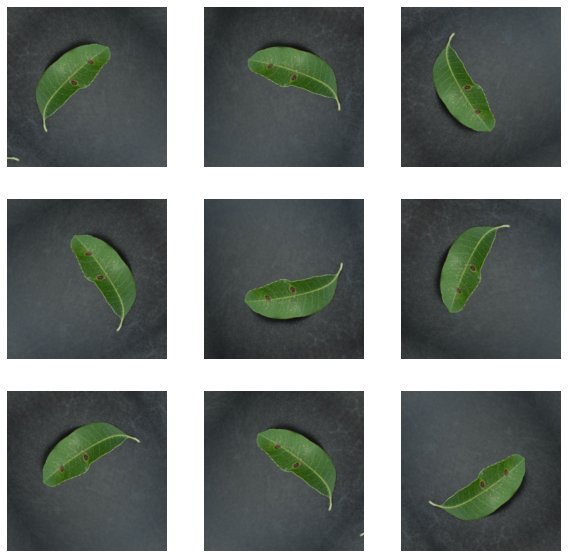

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
      augmented_image = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0].numpy().astype("uint8"))
      plt.axis("off")

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
11/11 [==============================] - 34s 3s/step - loss: 0.6338 - accuracy: 0.6254 - val_loss: 0.6563 - val_accuracy: 0.5625
Epoch 2/20
11/11 [==============================] - 18s 2s/step - loss: 0.6017 - accuracy: 0.6254 - val_loss: 0.6505 - val_accuracy: 0.5625
Epoch 3/20
11/11 [==============================] - 17s 2s/step - loss: 0.5182 - accuracy: 0.6519 - val_loss: 0.5352 - val_accuracy: 0.5625
Epoch 4/20
11/11 [==============================] - 18s 2s/step - loss: 0.2696 - accuracy: 0.9056 - val_loss: 0.0433 - val_accuracy: 1.0000
Epoch 5/20
11/11 [==============================] - 18s 2s/step - loss: 0.1506 - accuracy: 0.9440 - val_loss: 0.2354 - val_accuracy: 0.9062
Epoch 6/20
11/11 [==============================] - 17s 2s/step - loss: 0.0938 - accuracy: 0.9705 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 7/20
11/11 [==============================] - 17s 2s/step - loss: 0.0492 - accuracy: 0.9882 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 8/20
11/11 [==

In [18]:
model_test1 = model.evaluate(test_ds)
print(model_test1)

2/2 [==============================] - 19s 647ms/step - loss: 0.1524 - accuracy: 0.9375
[0.1524142622947693, 0.9375]


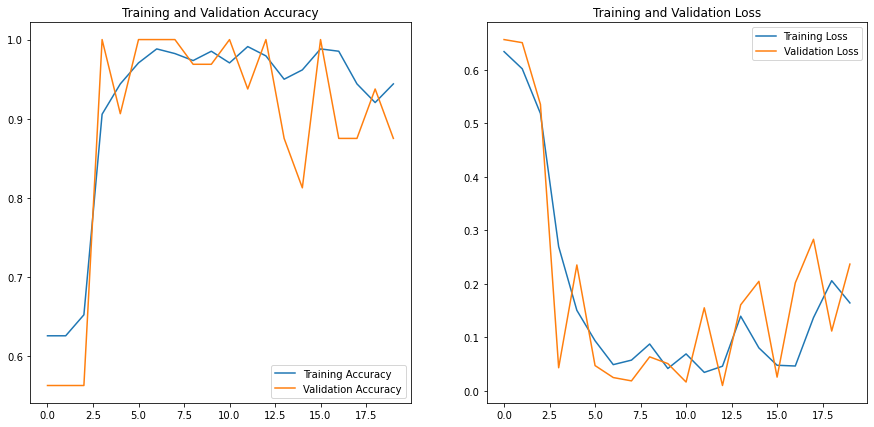

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label: diseased
1/1 [==============================] - 1s 932ms/step
predicted label: diseased


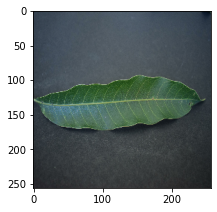

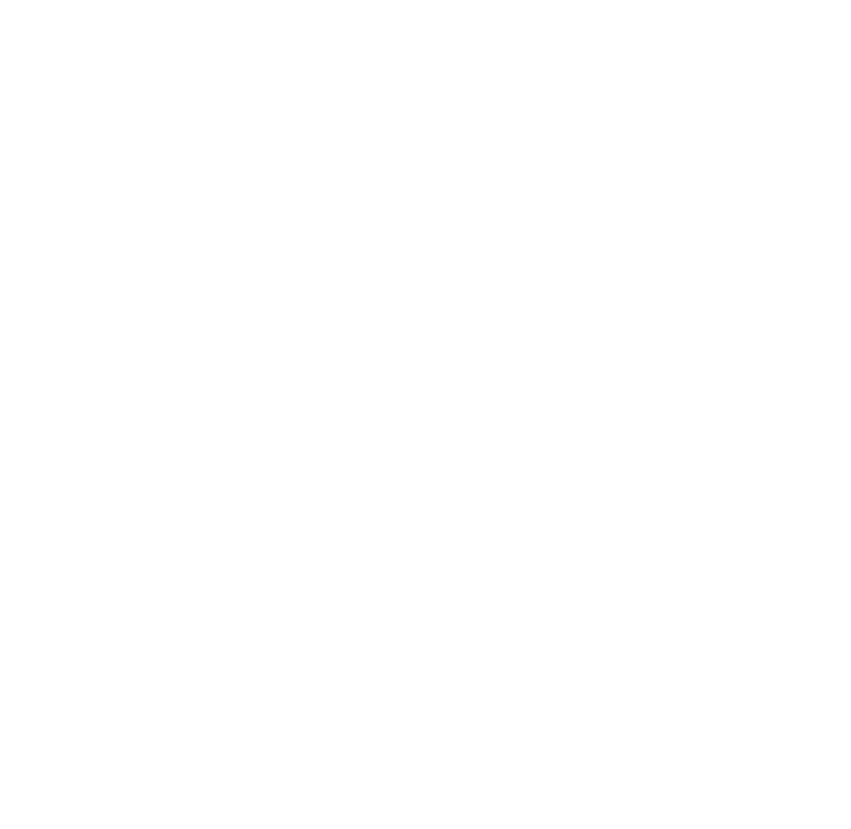

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
        plt.figure(figsize=(15, 15))        
   # for i in range(4):
        first_image = images_batch[i].numpy().astype('uint8')
        first_label = labels_batch[i].numpy().astype('uint8')
        plt.subplot(4,3,i+1)
        plt.imshow(first_image)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
                                                                                                                                                        #plt.imshow(first_image)
        print("actual label:",class_names[first_label])
    
        batch_prediction = model.predict(images_batch)
        print("predicted label:",class_names[np.argmax(batch_prediction[i])])
        plt.axis('off')

In [21]:
tl_model = tf.keras.applications.ResNet50V2(include_top=False)
tl_model.trainable = False
inputs = layers.Input(shape=(256, 256, 3), name='input_layer')
x = tl_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

In [22]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
model_2.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [24]:
history = model_2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=6,
)

Epoch 1/6
11/11 [==============================] - 45s 4s/step - loss: 3.9681 - accuracy: 0.6490 - val_loss: 3.7667 - val_accuracy: 0.5000
Epoch 2/6
11/11 [==============================] - 40s 4s/step - loss: 1.8576 - accuracy: 0.7463 - val_loss: 1.6796 - val_accuracy: 0.5938
Epoch 3/6
11/11 [==============================] - 40s 4s/step - loss: 0.7632 - accuracy: 0.8319 - val_loss: 0.2826 - val_accuracy: 0.8750
Epoch 4/6
11/11 [==============================] - 39s 4s/step - loss: 0.5607 - accuracy: 0.8791 - val_loss: 0.1642 - val_accuracy: 0.9062
Epoch 5/6
11/11 [==============================] - 39s 4s/step - loss: 0.4730 - accuracy: 0.8968 - val_loss: 0.0395 - val_accuracy: 0.9688
Epoch 6/6
11/11 [==============================] - 39s 4s/step - loss: 0.4098 - accuracy: 0.8997 - val_loss: 0.0340 - val_accuracy: 1.0000


In [25]:
model_test = model_2.evaluate(test_ds)
print(model_test)

2/2 [==============================] - 6s 3s/step - loss: 0.4518 - accuracy: 0.8750
[0.4518128037452698, 0.875]


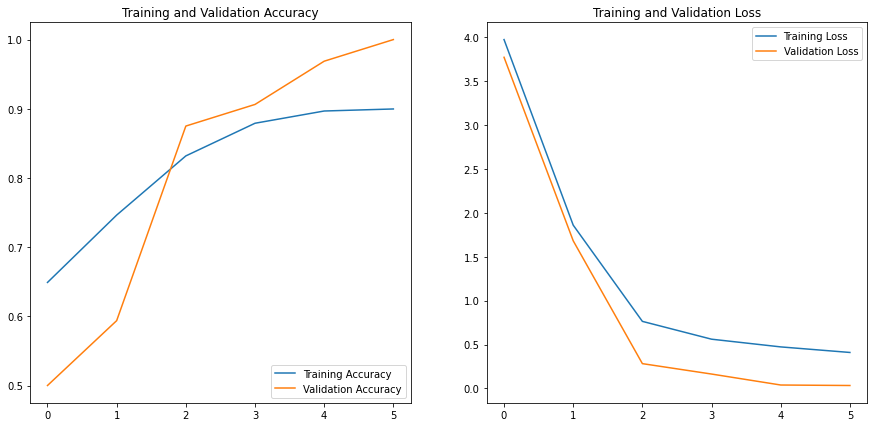

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
tl_model = tf.keras.applications.InceptionV3(include_top=False)
tl_model.trainable = False
inputs = layers.Input(shape=(256, 256, 3), name='input_layer')
x = tl_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

In [29]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
model_3.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [31]:
history = model_3.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
11/11 [==============================] - 23s 2s/step - loss: 1.8729 - accuracy: 0.6932 - val_loss: 0.7168 - val_accuracy: 0.7500
Epoch 2/20
11/11 [==============================] - 20s 2s/step - loss: 1.1637 - accuracy: 0.7257 - val_loss: 1.2001 - val_accuracy: 0.6875
Epoch 3/20
11/11 [==============================] - 21s 2s/step - loss: 0.6653 - accuracy: 0.8112 - val_loss: 1.0513 - val_accuracy: 0.7188
Epoch 4/20
11/11 [==============================] - 21s 2s/step - loss: 0.6174 - accuracy: 0.8201 - val_loss: 0.5678 - val_accuracy: 0.8125
Epoch 5/20
11/11 [==============================] - 21s 2s/step - loss: 0.5846 - accuracy: 0.8083 - val_loss: 0.6267 - val_accuracy: 0.7812
Epoch 6/20
11/11 [==============================] - 21s 2s/step - loss: 0.4156 - accuracy: 0.8732 - val_loss: 0.7124 - val_accuracy: 0.7500
Epoch 7/20
11/11 [==============================] - 21s 2s/step - loss: 0.2716 - accuracy: 0.8820 - val_loss: 0.3862 - val_accuracy: 0.8438
Epoch 8/20
11/11 [==

In [32]:
model_test = model_3.evaluate(test_ds)
print(model_test)

2/2 [==============================] - 5s 3s/step - loss: 0.4334 - accuracy: 0.7969
[0.43339812755584717, 0.796875]


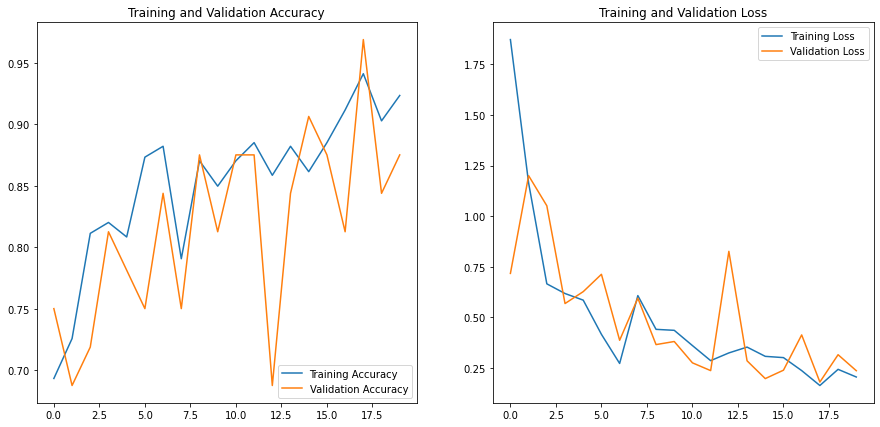

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
tl_model = tf.keras.applications.VGG19(include_top=False)
tl_model.trainable = False
inputs = layers.Input(shape=(256, 256, 3), name='input_layer')
x = tl_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_4 = tf.keras.Model(inputs, outputs)

In [35]:
model_4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [36]:
model_4.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [37]:
history = model_4.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
11/11 [==============================] - 199s 18s/step - loss: 0.8729 - accuracy: 0.6490 - val_loss: 1.0491 - val_accuracy: 0.5000
Epoch 2/20
11/11 [==============================] - 194s 18s/step - loss: 0.7279 - accuracy: 0.6785 - val_loss: 1.1577 - val_accuracy: 0.5938
Epoch 3/20
11/11 [==============================] - 190s 17s/step - loss: 0.5729 - accuracy: 0.7021 - val_loss: 0.7928 - val_accuracy: 0.5938
Epoch 4/20
11/11 [==============================] - 147s 13s/step - loss: 0.5332 - accuracy: 0.7522 - val_loss: 0.7699 - val_accuracy: 0.6250
Epoch 5/20
11/11 [==============================] - 115s 10s/step - loss: 0.4366 - accuracy: 0.7965 - val_loss: 0.6769 - val_accuracy: 0.6562
Epoch 6/20
11/11 [==============================] - 114s 10s/step - loss: 0.4614 - accuracy: 0.7758 - val_loss: 0.6440 - val_accuracy: 0.6875
Epoch 7/20
11/11 [==============================] - 121s 11s/step - loss: 0.4235 - accuracy: 0.7788 - val_loss: 0.6032 - val_accuracy: 0.7188
Epoch 

In [38]:
model_test = model_4.evaluate(test_ds)
print(model_test)

2/2 [==============================] - 37s 18s/step - loss: 0.2889 - accuracy: 0.9219
[0.28885623812675476, 0.921875]


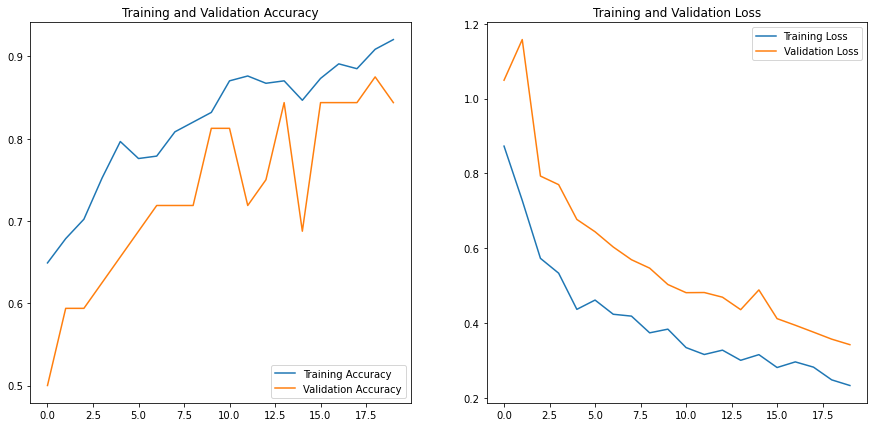

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()